How does our Y1 TFR compare with that of Cosmicflows-4?

Also, how do our rotational velocities compare with ALFALFA's (which is what Cosmicflows-4 used)?

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, unique, join
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
from astropy import units as u
import astropy.constants as const

import pickle

from scipy.optimize import minimize
from scipy.stats import binned_statistic

from tqdm import tqdm

import matplotlib.pyplot as plt
import os
import requests
from astropy.wcs import WCS
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import pandas as pd

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from z_CMB_convert import convert_z_frame
from help_functions import profile_histogram

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Iron

In [3]:
# data_directory = '.'
data_directory = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y1/'
# data_directory = '/Users/kdouglass/Documents/Research/data/DESI/Y1/'

hdul = fits.open(data_directory + 'DESI-DR1_TF_pv_cat_v13.fits')
# hdul = fits.open(data_directory + 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits')
# hdul = fits.open(data_directory + 'SGA_iron_jointTFR-varyV0-perpdwarf_zCMB0p1_AnthonyUpdates_weightsVmax-1_dVsys_moduli.fits')
# hdul = fits.open(data_directory + 'SGA_iron_jointTFR-varyV0-perpdwarf_zCMB0p1_Anthony2_weightsVmax-1_dVsys_moduli.fits')
# hdul = fits.open(data_directory + 'SGA_iron_jointTFR-zbin0p005-dwarfAlex_zCMB0p1_weightsVmax-1_dVsys_moduli.fits')
hdr = hdul[0].header
SGA = Table(hdul[1].data)
hdul.close()

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN,V_PEC,VERR_PEC
float64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,str10,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.0469

# Distance Moduli Comparison

In [4]:
cftab1 = Table.read('CF4/table1.fits')['PGC','rcmag','Wmx', 'e_Wmx', '_RA','_DE'].to_pandas().dropna()
cftab4 = Table.read('CF4/table4.fits')['PGC','Vls','Vcmb','DM-r','e_DM-r', 'RMS-r', 'e_DMbest','DMbest'].to_pandas().dropna()
cf4 = pd.merge(cftab1, cftab4, left_on=['PGC'], right_on=['PGC'])

cf4

,PGC,rcmag,Wmx,e_Wmx,_RA,_DE,Vls,Vcmb,DM-r,e_DM-r,RMS-r,e_DMbest,DMbest
0,4,15.690000,154,5,0.014625,23.087528,4706,4109,33.310001,0.16,0.56,0.17,33.290001
1,16,14.120000,297,14,0.046989,-5.158863,5809,5312,34.700001,0.23,0.39,0.24,34.700001
2,55,15.580000,179,10,0.156000,33.600583,5052,4454,34.000000,0.23,0.56,0.24,34.000000
3,68,14.790000,206,18,0.230717,-18.959111,7740,7338,34.799999,0.36,0.52,0.37,34.810001
4,70,14.460000,433,5,0.233529,20.337928,7040,6447,35.099998,0.12,0.35,0.12,35.119999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,5952956,15.050000,368,6,231.546833,8.907417,10678,10806,36.060001,0.14,0.35,0.14,36.020000
6765,5953001,13.620000,288,5,236.414542,28.089167,2272,2249,33.240002,0.13,0.46,0.13,33.230000
6766,6719321,16.809999,73,5,0.205142,5.106519,3281,2732,31.990000,0.27,0.56,0.28,32.029999
6767,6724069,16.090000,113,5,14.044679,21.459447,7417,6880,34.139999,0.27,0.56,0.28,34.150002


In [5]:
c = const.c.to('km/s')
# iron_HI['Vhelio_DESI'] = c*((1+iron_HI['Z_DESI'])**2 -1)/((1+iron_HI['Z_DESI'])**2 +1)
cf4['Z_CF_CMB'] = np.sqrt((1+ cf4['Vcmb']/c.value)/(1-cf4['Vcmb']/c.value))-1

In [6]:
cf4

,PGC,rcmag,Wmx,e_Wmx,_RA,_DE,Vls,Vcmb,DM-r,e_DM-r,RMS-r,e_DMbest,DMbest,Z_CF_CMB
0,4,15.690000,154,5,0.014625,23.087528,4706,4109,33.310001,0.16,0.56,0.17,33.290001,0.013801
1,16,14.120000,297,14,0.046989,-5.158863,5809,5312,34.700001,0.23,0.39,0.24,34.700001,0.017879
2,55,15.580000,179,10,0.156000,33.600583,5052,4454,34.000000,0.23,0.56,0.24,34.000000,0.014969
3,68,14.790000,206,18,0.230717,-18.959111,7740,7338,34.799999,0.36,0.52,0.37,34.810001,0.024784
4,70,14.460000,433,5,0.233529,20.337928,7040,6447,35.099998,0.12,0.35,0.12,35.119999,0.021741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,5952956,15.050000,368,6,231.546833,8.907417,10678,10806,36.060001,0.14,0.35,0.14,36.020000,0.036719
6765,5953001,13.620000,288,5,236.414542,28.089167,2272,2249,33.240002,0.13,0.46,0.13,33.230000,0.007530
6766,6719321,16.809999,73,5,0.205142,5.106519,3281,2732,31.990000,0.27,0.56,0.28,32.029999,0.009155
6767,6724069,16.090000,113,5,14.044679,21.459447,7417,6880,34.139999,0.27,0.56,0.28,34.150002,0.023219


In [7]:
cf4_scatter = np.mean(cf4['RMS-r'])

In [8]:
## Sky coordinates of SGA galaxies that passed quality selection
sga_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

## sky coordinates of the Williams catalog galaxies
cf_coords = SkyCoord(cf4['_RA'], cf4['_DE'], unit='deg')

match_ids, match_dist, _ = sga_coords.match_to_catalog_sky(cf_coords)
print(len(match_ids),len(SGA), len(cf4))
## Let's use these matches to add the group as a new column in our table
SGA['RA_CF4'] = cf4['_RA'][match_ids]
SGA['DEC_CF4']= cf4['_DE'][match_ids]
SGA['CF_DM-r'] = cf4['DM-r'][match_ids]
SGA['CF_DMbest'] = cf4['DMbest'][match_ids]
SGA['CF_DM-r_err'] = cf4['e_DM-r'][match_ids]
SGA['CF_DMbest_err'] = cf4['e_DMbest'][match_ids]
SGA['Z_CF4'] = cf4['Z_CF_CMB'][match_ids]
SGA['CF_rmag'] = cf4['rcmag'][match_ids]
SGA['CF_Wmx'] = cf4['Wmx'][match_ids]
SGA['CF_Wmx_err'] = cf4['e_Wmx'][match_ids]

#### now let's get the relative separation which is the separation divided by R26
SGA['rel_sep'] = (2 * match_dist.to('arcmin')) / (SGA['D26']*u.arcmin)

10262 10262 6769


In [9]:
matched = SGA[SGA['rel_sep'] < 0.1]
len(matched)

299

In [10]:
matched[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN,V_PEC,VERR_PEC,RA_CF4,DEC_CF4,CF_DM-r,CF_DMbest,CF_DM-r_err,CF_DMbest_err,Z_CF4,CF_rmag,CF_Wmx,CF_Wmx_err,rel_sep
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,str10,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float32,float32,float32,float32,float64,float32,int16,int16,float64
2733.0,SGA-2020 2733,PGC053490,53490,224.5346505,3.4234858999999997,Sc,19.59,0.71121347,0.36982816,0.021503542,23.417482,15.529,False,LEDA-20181114,764,PGC053490,1,True,224.5346505,3.4234858999999997,0.71121347,2244p035,224.5346064224481,3.4235575917512113,1.4237266,SB26,19.876198,0.3149386,224.5344624475489,3.423579549171879,30.893896,11.92165,11.981146,11.625645,13.907607,17.39407,20.447905,23.176737,25.917902,28.476297,32.013275,37.15986,42.711796,16.10685,15.480221,14.926454,15.883679,15.25977,14.720405,15.759376,15.12896,14.608543,15

In [11]:
matched['MU_ZCMB','CF_DM-r','CF_DMbest', 'MU_ZCMB_ERR', 'CF_DM-r_err', 'CF_DMbest_err', 'Z_DESI_CMB', 'Z_CF4']

MU_ZCMB,CF_DM-r,CF_DMbest,MU_ZCMB_ERR,CF_DM-r_err,CF_DMbest_err,Z_DESI_CMB,Z_CF4
float64,float32,float32,float64,float32,float32,float64,float64
34.15030552383372,34.39,34.39,0.0022819544279023287,0.14,0.14,0.022180656180810665,0.02243017110043577
35.34461545118312,36.73,36.75,0.0013631369439013488,0.29,0.31,0.038001243404628404,0.03880884533701745
35.54136818064265,36.28,36.28,0.0013573069828594954,0.18,0.19,0.041500159767041245,0.042309601302889854
33.30257671971319,34.26,34.27,0.01094070447173777,0.41,0.43,0.01509124235081849,0.015216199757675186
33.215234617591605,34.29,34.27,0.003578954967553233,0.15,0.16,0.014502681345075707,0.01461346798760621
34.4140959916005,35.18,35.18,0.002064949337947517,0.26,0.27,0.024993553458726225,0.025273197774384082
33.4517480546708,34.13,34.14,0.003356396153472153,0.27,0.28,0.016151552483428144,0.016266782163765425
32.008584854274325,32.73,32.73,0.006788593915704658,0.18,0.18,0.008358530712106571,0.008397711412173381
30.57445067222011,32.0,32.01,0.01245895108770806,0.45,0.47,0.004331432973650351,0.00432232491034501


In [12]:
matched['Z_diff'] = matched['Z_CF4'] - matched['Z_DESI_CMB'] 

In [13]:
dwarf_boolean = ~matched['MAIN']

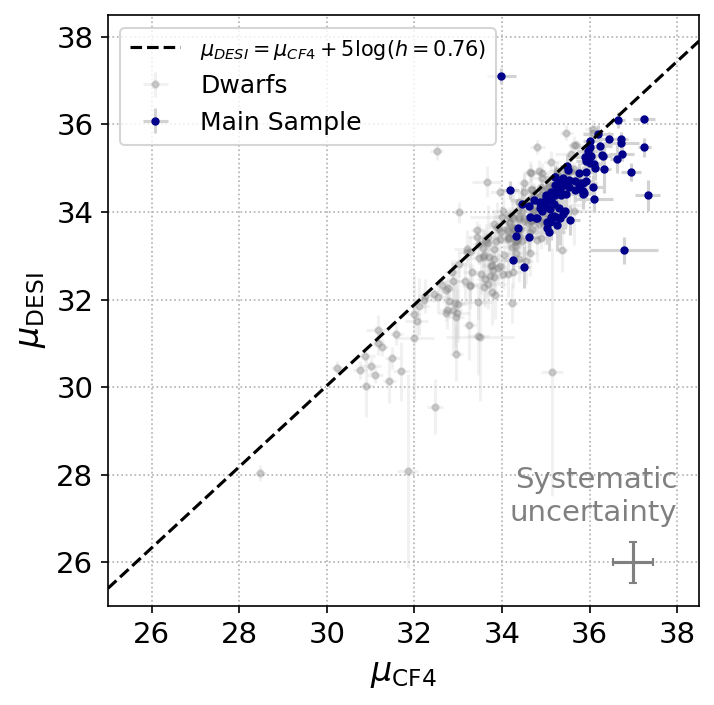

In [14]:
H0 = 76.0 # From Kourkchi et al. (2020a)
h = H0/100

#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True, dpi=150)


plt.grid(ls=':')

# plt.plot([26, 38], [26, 38], '--', color='k', zorder=3, alpha=0.5, label='y=x')  # lightgray color if showing the H0 from CF4
plt.plot([25, 38.5], np.array([26, 38.5]) + 5*np.log10(h), 'k--', zorder=4, label=r'$\mu_{DESI} = \mu_{CF4} +5\log(h=0.76)$') # with H0 from Cosmicflows 4

plt.errorbar(y=matched['MU_TF'][dwarf_boolean], x=matched['CF_DM-r'][dwarf_boolean], 
             yerr=np.sqrt(matched['MU_TF_ERR'][dwarf_boolean]**2 - hdr['SIG']**2), 
             xerr=matched['CF_DM-r_err'][dwarf_boolean], 
             fmt='.', 
             alpha=0.3, 
             color='gray',
             ecolor='lightgray',
             label='Dwarfs')

plt.errorbar(y=matched['MU_TF'][~dwarf_boolean], x=matched['CF_DM-r'][~dwarf_boolean], 
             yerr=np.sqrt(matched['MU_TF_ERR'][~dwarf_boolean]**2 - hdr['SIG']**2), 
             xerr=matched['CF_DM-r_err'][~dwarf_boolean], 
             fmt='.', 
             alpha=1, 
             color='darkblue',
             ecolor='lightgray',
             label='Main Sample')


# plt.errorbar(matched['MU_ZCMB'], matched['CF_DMbest'], 
#              xerr=matched['MU_ZCMB_ERR'], 
#              yerr=matched['CF_DMbest_err'], 
#              fmt='.', 
#              alpha=0.2, 
#              ecolor='gray')
# sc = plt.scatter(matched['MU_ZCMB'], matched['CF_DM-r'], 
#              c = np.abs(matched['MU_ZCMB'] - matched['CF_DM-r']), zorder=2, s=5, cmap='viridis_r', alpha=0.8,  vmin=0, vmax=2,)

# Systematic error bar example
plt.errorbar([37], [26], 
             xerr=cf4_scatter, #CF scatter (mean RMS for r-band)
             yerr=hdr['SIG'], #DESI scatter
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=2)
plt.annotate('Systematic\nuncertainty', 
             (38, 27.5), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray',
             fontsize=14)

plt.gca().set_aspect('equal')

plt.xlim([25, 38.5])
plt.ylim([25, 38.5])

plt.ylabel(r'$\mu_{\text{DESI}}$', fontsize=16)
plt.xlabel(r'$\mu_{\text{CF4}}$', fontsize=16);
plt.legend(fontsize=12).get_texts()[0].set_fontsize(10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()

# cbar = plt.colorbar(sc)
# cbar.set_label('Redshift')
# plt.savefig('../../Figures/Y1/iron_CF4comp_Anthony2_20250717.png', 
plt.savefig('iron_CF4comp_20251120.png',
            dpi=150, 
            facecolor='none');

In [15]:
print(hdr['SIG'], cf4_scatter)

0.46591813563738443 0.45675576


In [16]:
#### For consistency, adjust the CF magnitude errors to unclude their scatter

matched['CF_DM-r_err'] = np.sqrt(matched['CF_DM-r_err']**2 + cf4_scatter**2)

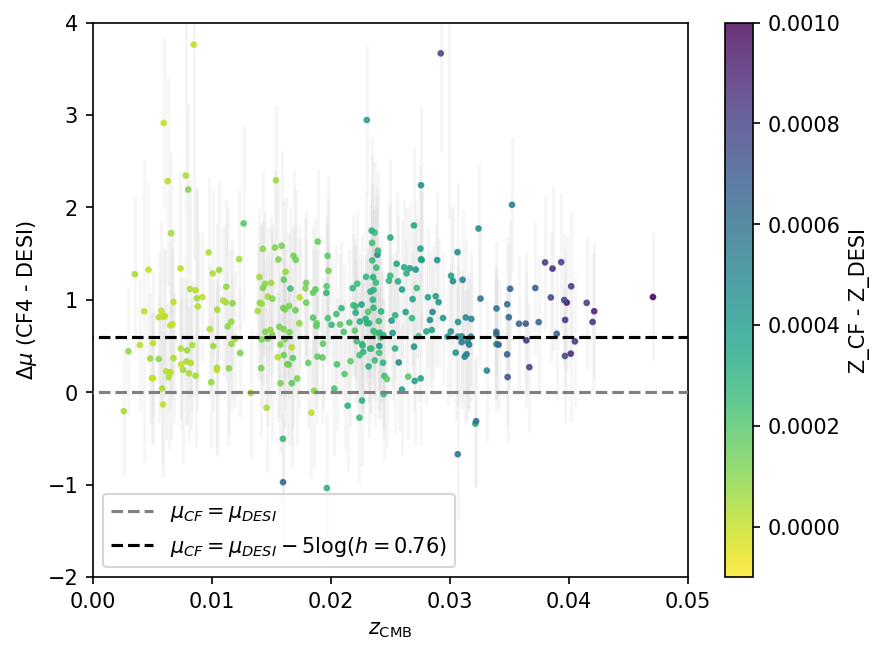

In [17]:
vbins = np.arange(0, 0.08, 0.005)

plt.figure(dpi=150)
plt.errorbar(x=matched['Z_DESI_CMB'], 
             y=matched['CF_DM-r'] - matched['MU_TF'], 
             xerr=matched['ZERR_DESI'], 
             yerr=np.sqrt(matched['MU_TF_ERR']**2 + matched['CF_DM-r_err']**2),
             fmt='.',
             markersize=0,
             alpha=0.2, 
             ecolor='lightgray')
sc = plt.scatter(x=matched['Z_DESI_CMB'], 
             y=matched['CF_DM-r'] - matched['MU_TF'], 
             c = np.abs(matched['Z_diff']), zorder=2, s=5, cmap='viridis_r', alpha=0.8, vmin=-0.0001, vmax=0.001)

# Plot the median
# N, y_avg, y_std = profile_histogram(matched['Z_DESI_CMB'], 
#                                     matched['MU_TF'] - matched['CF_DM-r'], 
#                                     zbins)
# plt.errorbar(zc, y_avg, yerr=y_std, fmt='x', color='darkblue', zorder=5)

# Plot a horizontal line at 0
plt.hlines(0, -0.1, 0.15, colors='grey', linestyles='dashed', zorder=4, label=r'$\mu_{CF} = \mu_{DESI}$')
plt.hlines(-5*np.log10(0.76), -0.1, 0.15, colors='k', linestyles='dashed', zorder=4, label=r'$\mu_{CF} = \mu_{DESI} - 5\log(h=0.76)$')

plt.xlim(0, 0.05)
plt.ylim(-2, 4)

plt.xlabel(r'$z_\text{CMB}$')
plt.ylabel(r'$\Delta \mu$ (CF4 - DESI)');
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Z_CF - Z_DESI')

In [18]:
##### calculating mean and standard deviation (adjusted for H0 difference)
diff = matched['CF_DM-r'] - matched['MU_TF'] +5*np.log10(0.76)
print(f'Mean difference = {np.mean(diff):.3f}')
print(f'Standard deviation = {np.std(diff):.3f}')

Mean difference = 0.206
Standard deviation = 0.712


In [19]:
##### Raw differences
diff = matched['CF_DM-r'] - matched['MU_TF']
print(f'Mean difference = {np.mean(diff):.3f}')
print(f'Standard deviation = {np.std(diff):.3f}')

Mean difference = 0.802
Standard deviation = 0.712


In [20]:
matched.write('CF4_DESI_overlap.fits', overwrite=True)

In [25]:
matched[:5]['SGA_ID','CF_Wmx', 'CF_Wmx_err','CF_DM-r', 'CF_DM-r_err','MAIN']

SGA_ID,CF_Wmx,CF_Wmx_err,MU_TF,CF_DM-r,CF_DM-r_err,MAIN
float64,int16,int16,float64,float32,float32,bool
2733.0,257,5,33.83563893900658,34.39,0.47772986,False
15509.0,415,29,35.32466105305762,36.73,0.54104143,True
18021.0,425,12,35.31207716429021,36.28,0.49094382,True
23113.0,179,18,33.63876070270259,34.26,0.61377996,False
24070.0,270,8,33.6356463652871,34.29,0.48075548,False


In [41]:
x = Table.read('CF4_DESI_overlap.fits')
x[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN,V_PEC,VERR_PEC,RA_CF4,DEC_CF4,CF_DM-r,CF_DMbest,CF_DM-r_err,CF_DMbest_err,Z_CF4,rel_sep,CF_rmag,CF_Wmx,Z_diff
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,bytes10,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float32,int16,float64
2733.0,SGA-2020 2733,PGC053490,53490,224.5346505,3.4234858999999997,Sc,19.59,0.71121347,0.36982816,0.021503542,23.417482,15.529,False,LEDA-20181114,764,PGC053490,1,True,224.5346505,3.4234858999999997,0.71121347,2244p035,224.5346064224481,3.4235575917512113,1.4237266,SB26,19.876198,0.3149386,224.5344624475489,3.423579549171879,30.893896,11.92165,11.981146,11.625645,13.907607,17.39407,20.447905,23.176737,25.917902,28.476297,32.013275,37.15986,42.711796,16.10685,15.480221,14.926454,15.883679,15.25977,14.720405,15.759376,15.12896,14.608543,15.677694,15.045603,14.541599,15.629486,15.00011,14.499654,15.601635,14.971489,14.472287,15.576543,14.945886,14.448134,15.554273,14.925001,14.422215,

In [44]:
matched[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN,V_PEC,VERR_PEC,RA_CF4,DEC_CF4,CF_DM-r,CF_DMbest,CF_DM-r_err,CF_DMbest_err,Z_CF4,rel_sep,CF_rmag,CF_Wmx,Z_diff
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,str10,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float32,int16,float64
2733.0,SGA-2020 2733,PGC053490,53490,224.5346505,3.4234858999999997,Sc,19.59,0.71121347,0.36982816,0.021503542,23.417482,15.529,False,LEDA-20181114,764,PGC053490,1,True,224.5346505,3.4234858999999997,0.71121347,2244p035,224.5346064224481,3.4235575917512113,1.4237266,SB26,19.876198,0.3149386,224.5344624475489,3.423579549171879,30.893896,11.92165,11.981146,11.625645,13.907607,17.39407,20.447905,23.176737,25.917902,28.476297,32.013275,37.15986,42.711796,16.10685,15.480221,14.926454,15.883679,15.25977,14.720405,15.759376,15.12896,14.608543,15.6